In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tqdm import tqdm
import time

In [3]:
SEED=42
random.seed(SEED)
torch.manual_seed(SEED)
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 70
g_lr = 0.0001
d_lr = 0.0004
beta1 = 0.5
ngpu=1

In [7]:
from torchvision import transforms, datasets as dset
import torch

# Normalize inputs between -1 and 1 using a different logic
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((image_size, image_size))),  # Resize using lambda
    transforms.CenterCrop(image_size),  # Center crop to image_size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0]*nc, std=[1]*nc)  # Normalize for nc channels
])

# Using CIFAR-10 dataset with specified transform
dataset = dset.CIFAR10(root='./data', train=True, download=True, transform=transform)


# Creating DataLoader with batch size, shuffling, and multiprocessing
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=bool(1), num_workers=len([0, 1]))


100%|██████████| 170498071/170498071 [00:02<00:00, 57654131.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


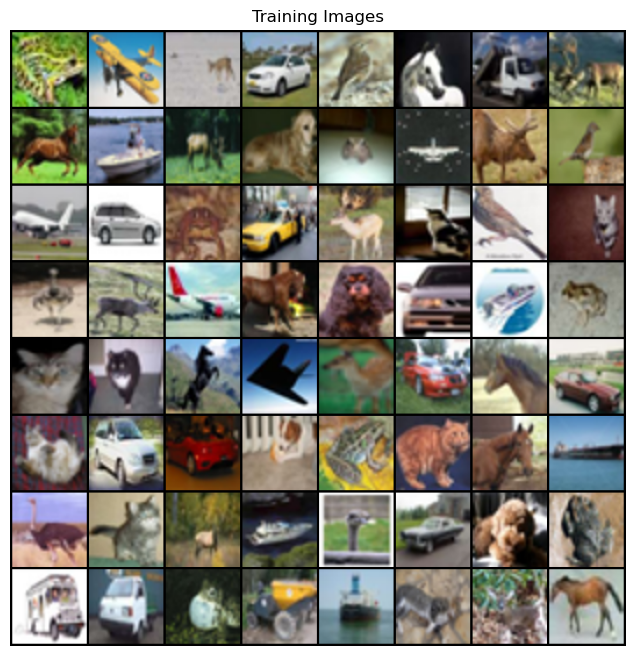

In [8]:
# Decide which device to use (CPU or GPU)
device = torch.device("cuda:0") if torch.cuda.is_available() and ngpu > 0 else torch.device("cpu")

# Get a batch of training images
for real_batch in dataloader:
    break  # Exit after fetching the first batch

# Plotting training images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

# Creating a grid of images
grid = vutils.make_grid(real_batch[0][:64].to(device), nrow=8, padding=2, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Use permute to rearrange dimensions


In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        # Define layers individually for clarity
        self.initial_layer = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True)
        )
        
        self.middle_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True)
        )
        
        self.middle_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True)
        )
        
        self.middle_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True)
        )
        
        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        # Forward pass through each layer
        x = self.initial_layer(input)
        x = self.middle_layer_1(x)
        x = self.middle_layer_2(x)
        x = self.middle_layer_3(x)
        return self.output_layer(x)


In [10]:
# Custom weights initialization function for netG and netD
def weights_init(m):
    # Check the type of the layer
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        # Apply normal initialization to convolutional layers
        nn.init.normal_(tensor=m.weight, mean=0.0, std=0.02)
    elif isinstance(m, nn.BatchNorm2d):
        # Apply normal initialization to BatchNorm weights and set bias to constant 0
        nn.init.normal_(tensor=m.weight, mean=1.0, std=0.02)
        nn.init.constant_(tensor=m.bias, val=0)


In [11]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (initial_layer): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (middle_layer_1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (middle_layer_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (middle_layer_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu

        # Defining each layer separately for modularity
        self.initial_layer = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.middle_layer_1 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.middle_layer_2 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.middle_layer_3 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.output_layer = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        # Explicit forward pass through each layer
        x = self.initial_layer(input)
        x = self.middle_layer_1(x)
        x = self.middle_layer_2(x)
        x = self.middle_layer_3(x)
        return self.output_layer(x)


In [13]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (initial_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (middle_layer_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (middle_layer_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (middle_layer_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (outpu

In [14]:
criterion = nn.BCELoss(reduction='mean')
real_label = torch.tensor(0.9, dtype=torch.float32)
fake_label = torch.tensor(0.1, dtype=torch.float32)
optimizerD = optim.Adam(params=[p for p in netD.parameters() if p.requires_grad],
                        lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(params=[p for p in netG.parameters() if p.requires_grad],
                        lr=g_lr, betas=(beta1, 0.999))


In [18]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of the default block to return
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their corresponding output blocks
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling features
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self, output_blocks=None, resize_input=True, normalize_input=True, requires_grad=False):
        super().__init__()

        # Set default output blocks if not provided
        output_blocks = output_blocks if output_blocks is not None else [self.DEFAULT_BLOCK_INDEX]
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        # Ensure the last needed block is valid
        if self.last_needed_block > 3:
            raise ValueError('Last possible output block index is 3.')

        # Load pretrained InceptionV3
        inception = models.inception_v3(pretrained=True)

        # Initialize blocks
        self.blocks = nn.ModuleList(self._create_blocks(inception))

        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

    def _create_blocks(self, inception):
        """Helper function to create and organize blocks."""
        blocks = []

        # Block 0: Input to maxpool1
        blocks.append(nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            blocks.append(nn.Sequential(
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            blocks.append(nn.Sequential(
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            blocks.append(nn.Sequential(
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ))

        return blocks

    def forward(self, x):
        """Get Inception feature maps.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape Bx3xHxW. Values are expected in range (0, 1).

        Returns
        -------
        List of torch.Tensor
            Feature maps corresponding to the selected output blocks.
        """
        outputs = []

        # Resize and normalize the input if specified
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = x.mul(2).sub(1)  # Scale from range (0, 1) to range (-1, 1)

        # Pass through blocks
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)
            if idx == self.last_needed_block:
                break

        return outputs


# Initialize InceptionV3 model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3(output_blocks=[block_idx])
model = model.cuda()


In [19]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    # Switch the model to evaluation mode
    model.eval()
    activations = np.zeros((len(images), dims))
    device = torch.device('cuda' if cuda else 'cpu')
    images = images.to(device)
    with torch.no_grad():  
        output = model(images)[0]
        if output.shape[2] != 1 or output.shape[3] != 1:
            output = F.adaptive_avg_pool2d(output, output_size=(1, 1))

    # Convert output to NumPy and reshape
    activations[:output.size(0)] = output.view(output.size(0), -1).cpu().numpy()
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    
    return mu, sigma


In [20]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Ensure dimensions match
    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'
    diff = mu1 - mu2
    sigma1_eps = sigma1 + np.eye(sigma1.shape[0]) * eps
    sigma2_eps = sigma2 + np.eye(sigma2.shape[0]) * eps
    covmean = linalg.sqrtm(sigma1_eps @ sigma2_eps, disp=False)[0]
    if not np.isfinite(covmean).all():
        print(f'Covariance product is singular; adjusting with {eps}')
        covmean = linalg.sqrtm((sigma1_eps).dot(sigma2_eps))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    tr_covmean = np.trace(covmean)

    # Final Frechet distance calculation
    result = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

    return result


In [21]:
def calculate_fretchet(images_real, images_fake, model):
    """
    Calculate the Frechet Inception Distance (FID) between two sets of images.
    """
    stats_real = calculate_activation_statistics(images_real, model, cuda=True)
    mu_1, std_1 = stats_real
    stats_fake = calculate_activation_statistics(images_fake, model, cuda=True)
    mu_2, std_2 = stats_fake
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)

    return fid_value


In [22]:
print("Generator Parameters:",sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in netD.parameters() if p.requires_grad))

Generator Parameters: 3576704
Discriminator Parameters: 2765568


Starting Training Loop...
[5/70]	Loss_D: 1.9338	Loss_G: 0.6089	Fretchet_Distance: 251.4246


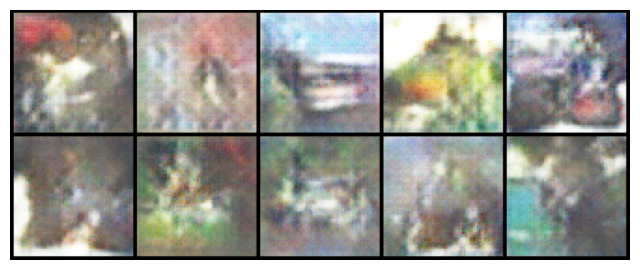

[10/70]	Loss_D: 0.9415	Loss_G: 1.1894	Fretchet_Distance: 242.3692


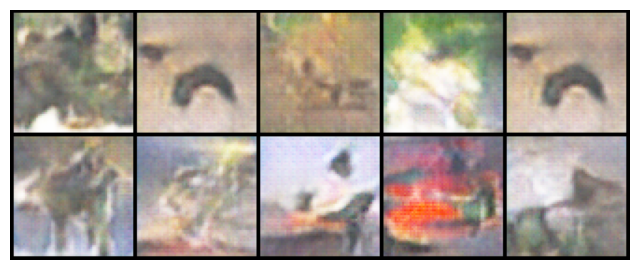

[15/70]	Loss_D: 0.9658	Loss_G: 1.6901	Fretchet_Distance: 251.3258


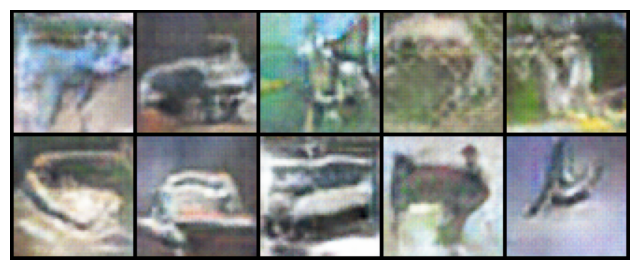

[20/70]	Loss_D: 0.8498	Loss_G: 1.6264	Fretchet_Distance: 257.7806


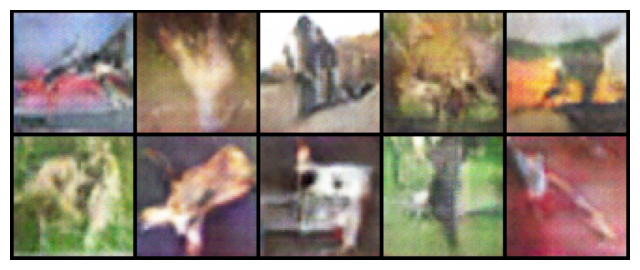

[25/70]	Loss_D: 0.9419	Loss_G: 1.6309	Fretchet_Distance: 250.8617


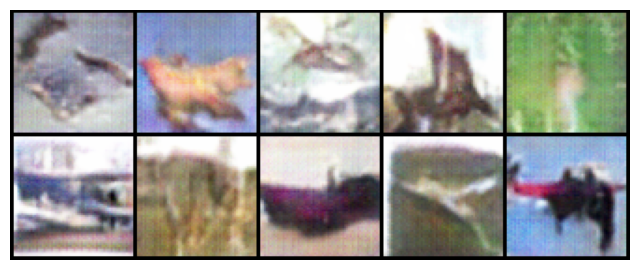

[30/70]	Loss_D: 0.8442	Loss_G: 3.1225	Fretchet_Distance: 248.7550


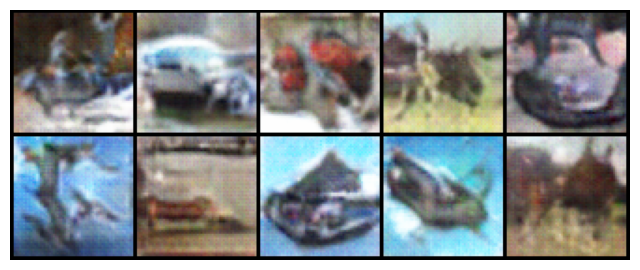

[35/70]	Loss_D: 1.1519	Loss_G: 7.2149	Fretchet_Distance: 262.0655


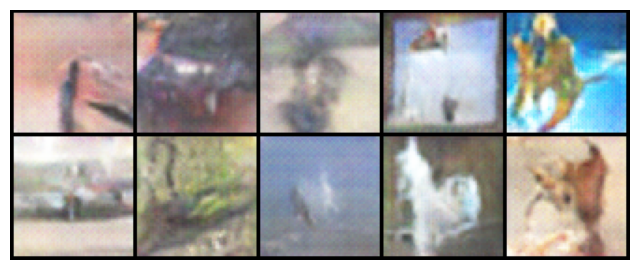

[40/70]	Loss_D: 1.2180	Loss_G: 1.2074	Fretchet_Distance: 244.3138


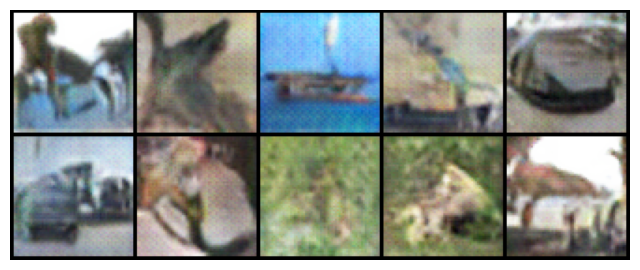

[45/70]	Loss_D: 1.4738	Loss_G: 0.3886	Fretchet_Distance: 237.5777


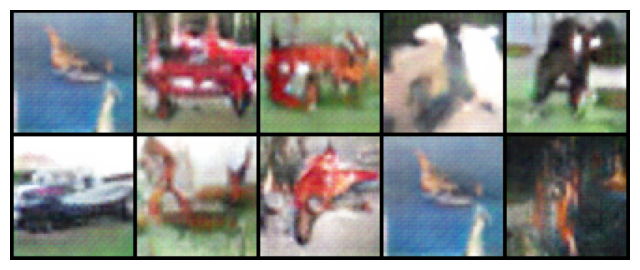

[50/70]	Loss_D: 0.7391	Loss_G: 2.1359	Fretchet_Distance: 269.6127


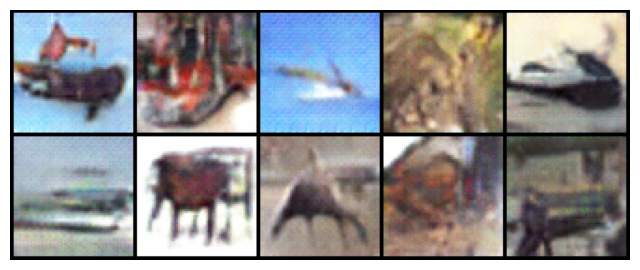

[55/70]	Loss_D: 0.7704	Loss_G: 2.9272	Fretchet_Distance: 251.7709


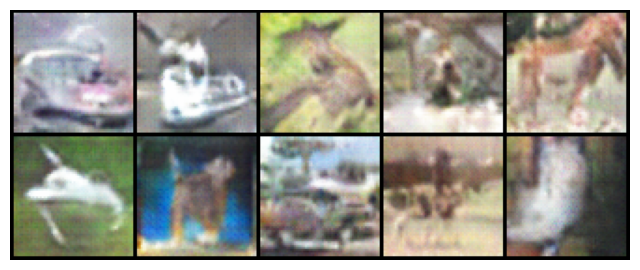

[60/70]	Loss_D: 0.8688	Loss_G: 4.1631	Fretchet_Distance: 292.8831


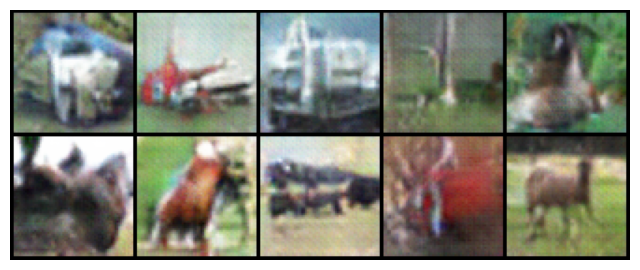

[65/70]	Loss_D: 0.9905	Loss_G: 1.7851	Fretchet_Distance: 277.1154


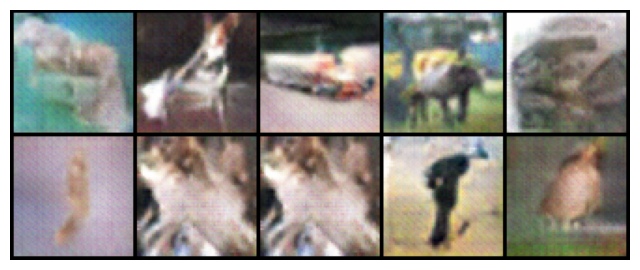

[70/70]	Loss_D: 0.9184	Loss_G: 1.3127	Fretchet_Distance: 251.5948


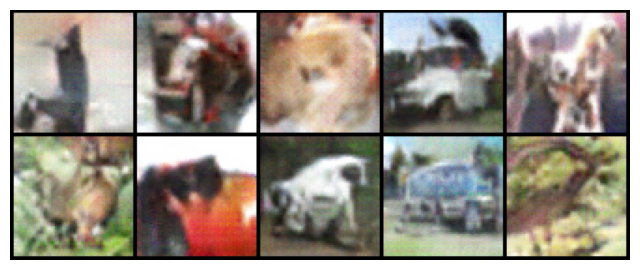

In [23]:
img_list = []
G_losses = []
D_losses = []
fid_list = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label_real = torch.full((b_size,), real_label, device=device)
        
        real_cpu = real_cpu * 0.9 + torch.randn(real_cpu.size(), device=device) * 0.1
        output_real = netD(real_cpu).view(-1)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label_fake = torch.full((b_size,), fake_label, device=device)
        fake = fake * 0.9 + torch.randn(fake.size(), device=device) * 0.1
        output_fake = netD(fake.detach()).view(-1)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        
        # Update Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        label_real.fill_(real_label)  
        output_fake_for_G = netD(fake).view(-1)
        errG = criterion(output_fake_for_G, label_real)
        errG.backward()
        optimizerG.step()
        if (iters % 500 == 0) or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))
        
        iters += 1
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    fretchet_dist = calculate_fretchet(real_cpu, fake, model)
    fid_list.append(fretchet_dist)
    if (epoch + 1) % 5 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f'
              % (epoch + 1, num_epochs, errD.item(), errG.item(), fretchet_dist))
        
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        random_samples = torch.randint(len(fake_display), (10,))
        pictures = vutils.make_grid(fake_display[random_samples], nrow=5, padding=2, normalize=True)
        plt.imshow(np.transpose(pictures, (1, 2, 0)))
        plt.show()


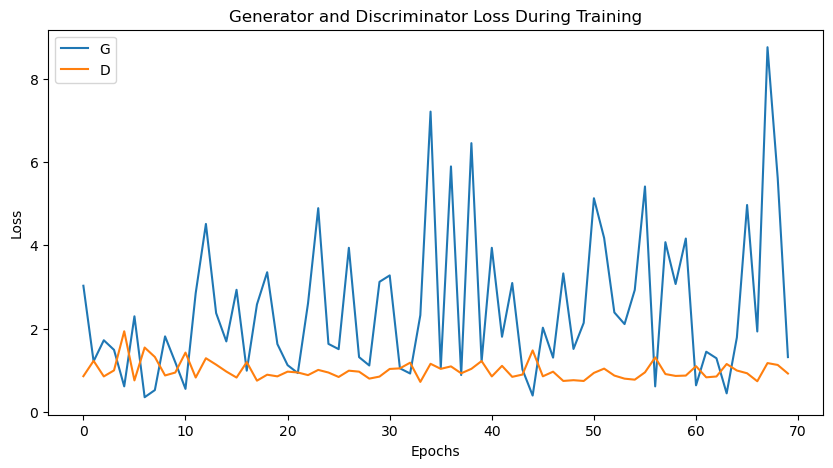

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

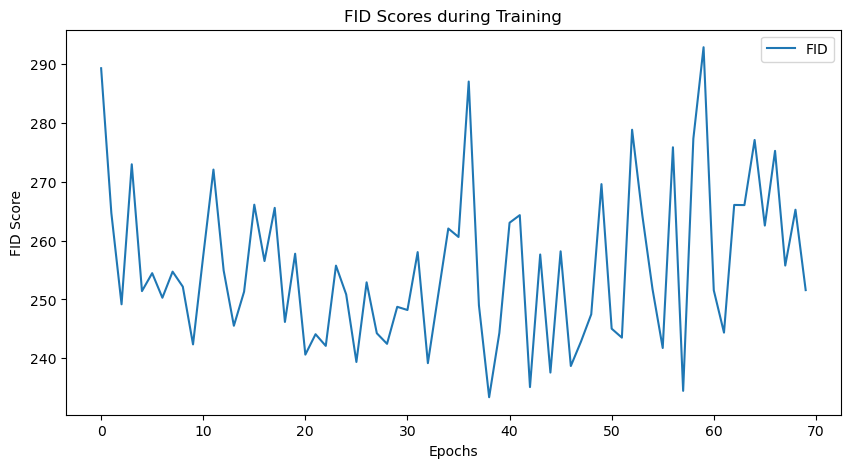

In [25]:
plt.figure(figsize=(10,5))
plt.title("FID Scores during Training")
plt.plot(fid_list,label="FID")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.legend()
plt.show()

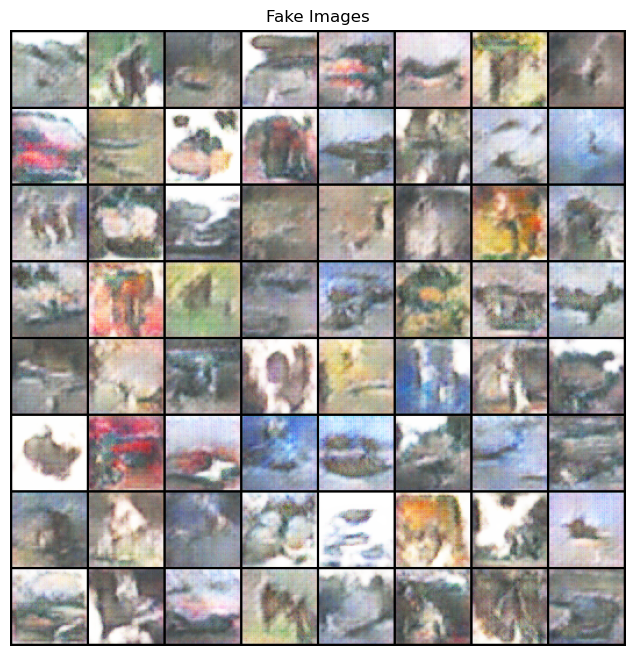

In [26]:
# Plot genearted images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[:10][-1],(1,2,0)))
plt.show()